In [250]:
import nltk
import pandas as pd
import numpy as np
import csv
import spacy
import re
import os
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
sp = spacy.load('en_core_web_sm')
from collections import Counter


[nltk_data] Downloading package wordnet to /Users/kc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [251]:
corpus_data = pd.read_csv('/Users/kc/Desktop/nlp/final_df.csv')
corpus_data.shape

(3457, 9)

In [252]:
corpus_data.dropna(subset=["Price"], inplace=True)

In [253]:
corpus_data.shape

(3440, 9)

In [254]:
tqdm.pandas()
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()
    
def tokenize_and_remove_numeric(text, modulation):
    if modulation < 2:
        tokens = re.split(r'\W+', text)
        processed_tokens = []
        for token in tokens:
            lowers = abbr_or_lower(token)
            if lowers not in stop_words and re.search('[a-zA-Z]', lowers):
                if modulation == 0:
                    processed_tokens.append(lowers)
                elif modulation == 1:
                    processed_tokens.append(porter.stem(lowers))
        return " ".join(processed_tokens)
    else:
        sp_text = sp(text)
        processed_tokens = []
        lemmatized_text = []
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        for w in lemmatized_text:
            w = abbr_or_lower(strip(w))
            if w and w not in stop_words and not w.isdigit():
                processed_tokens.append(w)
        return " ".join(processed_tokens)

def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector
    

In [255]:
corpus_data.info

<bound method DataFrame.info of                                                Hotels  Ratings  Price  \
0                                        Casa Abamita      8.5  € 740   
1                       Le Palacete powered by Sonder      8.1  € 925   
2                      Motel One Barcelona-Ciutadella      8.8  € 605   
3     TWO Hotel Barcelona by Axel 4* Sup- Adults Only      8.4  € 610   
4                   Inside Barcelona Apartments Sants      8.6  € 494   
...                                               ...      ...    ...   
3452                                  Cantagua Hostel      8.9  € 180   
3453                               UP Hostel Valencia      7.7  € 178   
3454                                Coworking Balance      7.8  € 166   
3455      Livensa Living Studios Valencia Marina Real      8.1  € 760   
3456                            HABITACION INDIVIDUAL      8.8  € 324   

                                       Promotion  \
0     Only 1 room left at this price on

In [256]:
mod=2
description_preproc = (
    corpus_data.Description
    .astype(str)
    .progress_apply(lambda row: tokenize_and_remove_numeric(row, mod))
)


corpus_data["description_preproc"]=description_preproc

print("done")

100%|██████████| 3440/3440 [00:32<00:00, 107.31it/s]

done


In [257]:
corpus_data = corpus_data.dropna(subset=['description_preproc']).reset_index(drop=True)


In [258]:
corpus_data.columns

Index(['Hotels', 'Ratings', 'Price', 'Promotion', 'Description', 'Link',
       'Place', 'From Date', 'To Day', 'description_preproc'],
      dtype='object')

In [259]:
corpus_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hotels               3439 non-null   object 
 1   Ratings              3263 non-null   float64
 2   Price                3440 non-null   object 
 3   Promotion            1816 non-null   object 
 4   Description          3439 non-null   object 
 5   Link                 3440 non-null   object 
 6   Place                3440 non-null   object 
 7   From Date            3440 non-null   object 
 8   To Day               3440 non-null   object 
 9   description_preproc  3440 non-null   object 
dtypes: float64(1), object(9)
memory usage: 268.9+ KB


In [260]:
print(corpus_data.Description[10])

Twin Room
Beds: 1 double or 2 singles
Breakfast included
Free cancellation
Only 1 room left at this price on our site
3 nights, 2 adults
€ 560
Price € 560
Includes taxes and charges
See availability


In [261]:
print(corpus_data.description_preproc[10])

twin room bed double single breakfast include free cancellation room leave price site night adult price include taxis charge see availability


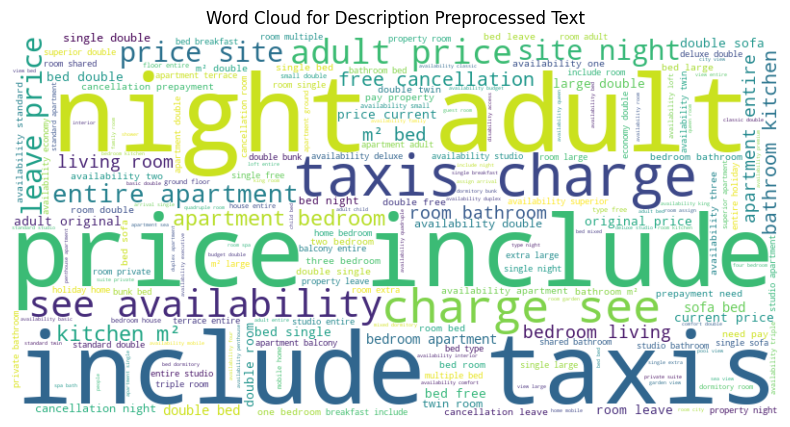

In [262]:
all_text = ' '.join(corpus_data['description_preproc'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Description Preprocessed Text')
plt.show()


In [263]:
vocab, index = {}, 1 
for doc in corpus_data.description_preproc:
    print(doc)
    tokens = doc.split()
    for token in tokens:
      if token not in vocab:
        vocab[token] = index
        index += 1
        

double twin room without views disability access multiple bed type free cancellation prepayment need pay property room leave price site night adult original price current price include taxis charge see availability
king room extra large double bed room leave price site night adult price include taxis charge see availability
double room double bed free cancellation prepayment need pay property night adult price include taxis charge see availability
double twin room large double bed night adult price include taxis charge see availability
studio adults entire apartment bedroom bathroom kitchen m² single bed night adult price include taxis charge see availability
double twin room bed double single room leave price site night adult original price current price include taxis charge see availability
double twin room bed double single free cancellation prepayment need pay property night adult price include taxis charge see availability
double twin room bed double single free cancellation prepa

In [274]:
vocab_stem=vocab
vocab_stem_size = len(vocab)
print(vocab_stem)
print(" ")
print("Total size of stemmed vocabulary:", vocab_stem_size)

{'double': 1, 'twin': 2, 'room': 3, 'without': 4, 'views': 5, 'disability': 6, 'access': 7, 'multiple': 8, 'bed': 9, 'type': 10, 'free': 11, 'cancellation': 12, 'prepayment': 13, 'need': 14, 'pay': 15, 'property': 16, 'leave': 17, 'price': 18, 'site': 19, 'night': 20, 'adult': 21, 'original': 22, 'current': 23, 'include': 24, 'taxis': 25, 'charge': 26, 'see': 27, 'availability': 28, 'king': 29, 'extra': 30, 'large': 31, 'studio': 32, 'adults': 33, 'entire': 34, 'apartment': 35, 'bedroom': 36, 'bathroom': 37, 'kitchen': 38, 'm²': 39, 'single': 40, 'balcony': 41, 'living': 42, 'sofa': 43, 'one': 44, 'terrace': 45, 'breakfast': 46, 'budget': 47, 'assign': 48, 'arrival': 49, 'interior': 50, 'private': 51, 'standard': 52, 'shared': 53, 'comfort': 54, 'triple': 55, 'basic': 56, 'superior': 57, 'window': 58, 'economy': 59, 'deluxe': 60, 'city': 61, 'view': 62, 'shower': 63, 'small': 64, 'premium': 65, 'two': 66, 'classic': 67, 'fourth': 68, 'floor': 69, 'calle': 70, 'meer': 71, 'pool': 72, 's

In [275]:
vectors=[]
for doc in corpus_data.description_preproc:
    vectors.append(vectorize(doc, vocab_stem))

df_corpus= pd.DataFrame(vectors)
df_corpus

,0,1,2,3,4,5,6,7,8,9,...,228,229,230,231,232,233,234,235,236,237
0,1,1,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435,0,0,2,0,0,0,0,0,8,0,...,0,0,0,0,0,0,0,0,0,0
3436,0,0,1,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
3437,0,0,1,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
3438,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
df_corpus.columns = vocab_stem.keys()
df_corpus

,double,twin,room,without,views,disability,access,multiple,bed,type,...,petit,conqueridor,maisonette,plaza,del,mercat,love,chalet,b02,b04
0,1,1,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435,0,0,2,0,0,0,0,0,8,0,...,0,0,0,0,0,0,0,0,0,0
3436,0,0,1,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
3437,0,0,1,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
3438,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [277]:
corpus_data.description_preproc[0]

['double',
 'twin',
 'room',
 'without',
 'views',
 'disability',
 'access',
 'multiple',
 'bed',
 'type',
 'free',
 'cancellation',
 'prepayment',
 'need',
 'pay',
 'property',
 'room',
 'leave',
 'price',
 'site',
 'night',
 'adult',
 'original',
 'price',
 'current',
 'price',
 'include',
 'taxis',
 'charge',
 'see',
 'availability']

In [284]:
cv = CountVectorizer(ngram_range = (1,3),  min_df=0.05,max_df=0.3, stop_words='english')
cv.fit(corpus_data.description_preproc)
vectorized_text=cv.transform(corpus_data.description_preproc)
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

document term matrix has size (3440, 93)
['adult original' 'adult original price' 'apartment bed'
 'apartment bedroom bathroom' 'bathroom m²' 'bed double'
 'bed double single' 'bed double sofa' 'bed free' 'bed free cancellation'
 'bed large' 'bed large double' 'bed leave' 'bed leave price' 'bed night'
 'bed night adult' 'bed room' 'bed room leave' 'bed single'
 'bed single double' 'bed sofa' 'bed sofa bed' 'bedroom apartment bed'
 'bedroom apartment entire' 'bedroom bathroom' 'bedroom bathroom kitchen'
 'cancellation leave' 'cancellation leave price' 'cancellation night'
 'cancellation night adult' 'cancellation prepayment'
 'cancellation prepayment need' 'current' 'current price'
 'current price include' 'double bed' 'double bed free' 'double bed night'
 'double bed room' 'double free' 'double free cancellation' 'double room'
 'double room double' 'double single' 'double sofa' 'double sofa bed'
 'double twin' 'double twin room' 'free cancellation leave'
 'free cancellation night' 'fre

In [285]:
print(cv.get_feature_names_out())

['adult original' 'adult original price' 'apartment bed'
 'apartment bedroom bathroom' 'bathroom m²' 'bed double'
 'bed double single' 'bed double sofa' 'bed free' 'bed free cancellation'
 'bed large' 'bed large double' 'bed leave' 'bed leave price' 'bed night'
 'bed night adult' 'bed room' 'bed room leave' 'bed single'
 'bed single double' 'bed sofa' 'bed sofa bed' 'bedroom apartment bed'
 'bedroom apartment entire' 'bedroom bathroom' 'bedroom bathroom kitchen'
 'cancellation leave' 'cancellation leave price' 'cancellation night'
 'cancellation night adult' 'cancellation prepayment'
 'cancellation prepayment need' 'current' 'current price'
 'current price include' 'double bed' 'double bed free' 'double bed night'
 'double bed room' 'double free' 'double free cancellation' 'double room'
 'double room double' 'double single' 'double sofa' 'double sofa bed'
 'double twin' 'double twin room' 'free cancellation leave'
 'free cancellation night' 'free cancellation prepayment'
 'kitchen m² d

In [286]:
for document in vectorized_text:
    print(document)

[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
  1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1
  1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]]
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
[[1 1 0 0 0 1 1 0 0 0 0 0 0 0 

In [287]:
cv_tfid = TfidfVectorizer(ngram_range = (1,3), norm=None)
cv_tfid.fit(corpus_data.description_preproc)
vectorized_text=cv.transform(corpus_data.description_preproc)
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

document term matrix has size (3440, 93)
['adult original' 'adult original price' 'apartment bed'
 'apartment bedroom bathroom' 'bathroom m²' 'bed double'
 'bed double single' 'bed double sofa' 'bed free' 'bed free cancellation'
 'bed large' 'bed large double' 'bed leave' 'bed leave price' 'bed night'
 'bed night adult' 'bed room' 'bed room leave' 'bed single'
 'bed single double' 'bed sofa' 'bed sofa bed' 'bedroom apartment bed'
 'bedroom apartment entire' 'bedroom bathroom' 'bedroom bathroom kitchen'
 'cancellation leave' 'cancellation leave price' 'cancellation night'
 'cancellation night adult' 'cancellation prepayment'
 'cancellation prepayment need' 'current' 'current price'
 'current price include' 'double bed' 'double bed free' 'double bed night'
 'double bed room' 'double free' 'double free cancellation' 'double room'
 'double room double' 'double single' 'double sofa' 'double sofa bed'
 'double twin' 'double twin room' 'free cancellation leave'
 'free cancellation night' 'fre

In [288]:
vectorized_text=vectorized_text.round(decimals=3, out=None)
for document in vectorized_text:
    print(document)

[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
  1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1
  1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]]
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
[[1 1 0 0 0 1 1 0 0 0 0 0 0 0 